In [17]:
## Import the modules

%matplotlib inline

import os
from pathlib import Path

import numpy as np
from scipy import stats
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import os
import sys
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GaussianNoise
from tensorflow.keras.optimizers import Adam
from skopt.plots import *

try:
    import sklearn
    from sklearn.utils import Bunch
except Exception as e:
    from .bunch import Bunch
    auto_log(f'Error importing sklearn: {e}', level='error')

try:
    import keras
except Exception as e:
    auto_log(f'Error importing Keras: {e}', level='error')


# Use single core to run this program
try:
    import tensorflow as tf
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)
    
    # Disable GPU acceleration. Swap platform.platform().startswith('Windows') and platform.machine() == 'AMD64' if necessary
    import platform
    if platform.platform().startswith('Windows') and platform.machine() == 'AMD64':
        tf.config.set_visible_devices([], 'GPU')

except Exception as e:
    auto_log(f'Error importing Tensorflow: {e}', level='error')

DATA_DIR = Path('.')

In [ ]:
## Import the modules

%matplotlib inline

import os
from pathlib import Path

import numpy as np
from scipy import stats
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import inspect
import logging
import os
import sys
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# from scikeras.wrappers import KerasRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.model_selection import cross_validate
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, r2_score
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_is_fitted
from sklearn.exceptions import NotFittedError
from sklearn.base import clone
from imblearn.over_sampling import SMOTENC

import matplotlib.colors as mcolors

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GaussianNoise
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold
from keras.wrappers.scikit_learn import KerasRegressor

from sklearn import svm
from matplotlib.widgets import Slider, Button 

from skopt import BayesSearchCV
from skopt.plots import *

import gc
import warnings


class SingleLevelFilter(logging.Filter):
    def __init__(self, passlevel, reject):
        super().__init__()
        self.passlevel = passlevel
        self.reject = reject

    def filter(self, record):
        if self.reject:
            return record.levelno != self.passlevel
        else:
            return record.levelno == self.passlevel

_FORMAT = '%(asctime)-15s - %(levelname)s - [%(funcfile)s -> %(func)s] %(message)s'
_formatter = logging.Formatter(_FORMAT)
logging.basicConfig(level='INFO')
auto_logger = logging.getLogger('BoC')
auto_logger.propagate = False
auto_logger.handlers = []
_ch1 = logging.StreamHandler(sys.stdout)
_ch1.setLevel(logging.INFO)
_ch1.setFormatter(_formatter)
_f1 = SingleLevelFilter(logging.INFO, False)
_ch1.addFilter(_f1)
_ch2 = logging.StreamHandler(sys.stderr)
_ch2.setLevel(logging.WARNING)
_ch2.setFormatter(_formatter)

auto_logger.addHandler(_ch1)
auto_logger.addHandler(_ch2)

def auto_log(message, level='info'):
    assert level in ['debug', 'info', 'warning', 'error', 'critical']
    func = inspect.currentframe().f_back.f_code
    eval('auto_logger.' + level)(message, extra={'func': func.co_name,
                                            'funcfile': os.path.basename(func.co_filename)}) 
try:
    import sklearn
    from sklearn.utils import Bunch
except Exception as e:
    from .bunch import Bunch
    auto_log(f'Error importing sklearn: {e}', level='error')

try:
    import keras
except Exception as e:
    auto_log(f'Error importing Keras: {e}', level='error')


# Use single core to run this program
try:
    import tensorflow as tf
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)
    
    # Disable GPU acceleration. Swap platform.platform().startswith('Windows') and platform.machine() == 'AMD64' if necessary
    import platform
    if platform.platform().startswith('Windows') and platform.machine() == 'AMD64':
        tf.config.set_visible_devices([], 'GPU')

except Exception as e:
    auto_log(f'Error importing Tensorflow: {e}', level='error')

DATA_DIR = Path('.')


In [2]:
## Import file and Define x and y columns
db_df = pd.read_csv(DATA_DIR / '0519_Dataset.new3.csv')

x_cols = ['MXene (mg/mL)', 'Laminin peptide (ug/mL)', 'Electric stimulation (Hz)', 'Voltage (V)']
y_cols = ['Cell viability (%)']

In [3]:
## Split the data into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(db_df[x_cols], db_df[y_cols], test_size=0.25, random_state=0)

In [4]:
## Define an ANN model

def ANN_model():

    # Fix random state
    tf.keras.backend.clear_session()
    tf.keras.utils.set_random_seed(0)

    # Create a simple ANN model for regression
    model = Sequential()
    model.add(Dense(64, input_dim=4, kernel_regularizer=keras.regularizers.L1(l1=1e-5)))

    # Add gausian noise before Activation
    model.add(GaussianNoise(stddev=0.033)) # 10 % of value change to data ranging from 0-1

    # Add activation function
    model.add(keras.layers.Activation('relu'))

    # Add other layers
    model.add(Dense(64, activation='relu', kernel_regularizer=keras.regularizers.L1(l1=1e-5)))
    model.add(Dense(1, activation='linear'))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse', metrics=['mae'])

    return model

In [5]:
## Normalize data
scalerX = MinMaxScaler().fit(X_train)
ANN_y_train = y_train / 100 # Normalize y to 0-1

In [6]:
## Train and Test the model
model = ANN_model()
history_test = model.fit(scalerX.transform(X_train), 
                         ANN_y_train, 
                         epochs=1000, 
                         batch_size=32, 
                         validation_data=(scalerX.transform(X_test), y_test/100)) # Normalize y_test to 0-1

Epoch 1/1000
7/7 [==============================] - 1s 35ms/step - loss: 0.5863 - mae: 0.6925 - val_loss: 0.4261 - val_mae: 0.5927
Epoch 2/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.5515 - mae: 0.6639 - val_loss: 0.3947 - val_mae: 0.5631
Epoch 3/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.5151 - mae: 0.6358 - val_loss: 0.3652 - val_mae: 0.5341
Epoch 4/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.4788 - mae: 0.6052 - val_loss: 0.3377 - val_mae: 0.5057
Epoch 5/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.4496 - mae: 0.5784 - val_loss: 0.3125 - val_mae: 0.4775
Epoch 6/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.4256 - mae: 0.5567 - val_loss: 0.2892 - val_mae: 0.4538
Epoch 7/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.3986 - mae: 0.5347 - val_loss: 0.2680 - val_mae: 0.4332
Epoch 8/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.3756 - mae: 0.5

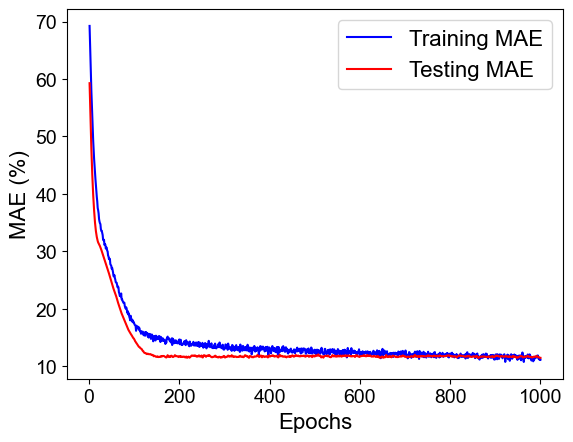

In [7]:
## Evaluate the model by MAE

# Extract training and validation MAE from the history object
train_mae = [x * 100 for x in history_test.history['mae']]
val_mae = [x * 100 for x in history_test.history['val_mae']]
epochs = range(1, len(train_mae) + 1)

# Plot
plt.plot(epochs, train_mae, 'b', label='Training MAE')
plt.plot(epochs, val_mae, 'r', label='Testing MAE')
plt.xlabel('Epochs', fontsize=16, fontname='Arial')
plt.ylabel('MAE (%)', fontsize=16, fontname='Arial')
plt.xticks(fontsize=14, fontname='Arial')
plt.yticks(fontsize=14, fontname='Arial')
plt.legend(prop={'family':'Arial', 'size':16})
# plt.savefig('FigS5.png', dpi=300, format='png')
plt.show()

In [8]:
## Define prediction
test_pred = model.predict((scalerX.transform(X_test)))

# Flatten the arrays before creating the DataFrame
ANN_y_test = y_test / 100
ANN_y_test_ravel = np.ravel(ANN_y_test)
test_pred_ravel = np.round(np.ravel(test_pred), decimals=2)

df = pd.DataFrame({'Test Value': ANN_y_test_ravel, 'Prediction': test_pred_ravel})

3/3 [==============================] - 0s 1ms/step


In [9]:
## Memorize the predict
from joblib import Memory
location = './cache'
memory = Memory(location, verbose=0)

cached_predict = memory.cache(model.predict)

def predict2(*args, **kwargs):
    return model.predict(*args, **kwargs)

cached_predict2 = memory.cache(predict2)

In [10]:
## Adjust default matplotlib plotting style

### patch start ###
from mpl_toolkits.mplot3d.axis3d import Axis
def _get_coord_info_new(self, renderer):
    mins, maxs, cs, deltas, tc, highs = self._get_coord_info_old(renderer)
    mins += deltas / 4
    maxs -= deltas / 4
    return mins, maxs, cs, deltas, tc, highs
if not hasattr(Axis, "_get_coord_info_old"):
    Axis._get_coord_info_old = Axis._get_coord_info
Axis._get_coord_info = _get_coord_info_new
### patch end ###


def get_fixed_lim(mins, maxs, blend=0):
    og_mins = (49 * mins + maxs) / 50
    og_maxs = (mins + 49 * maxs) / 50

    mix_mins = blend * og_mins + (1 - blend) * mins
    mix_maxs = blend * og_maxs + (1 - blend) * maxs
    return mix_mins, mix_maxs

In [11]:
## Define a function for using trained ANN model to generate 3d heatmaps
def ANN_gen_plot(predict=model.predict, npts=10, vmin=0, vmax=1, vcut=0, elev=35, azim=-125, af=1, s=10, cmap='YlGnBu', labelsize=14, dpi=100):
    
    xx = np.linspace(0, 0.3, num=npts)
    yy = np.linspace(0, 5.9, num=npts)
    zz = np.linspace(0, 3, num=npts)

    X, Y, Z = np.meshgrid(xx, yy, zz)

    # Volt
    voltage = [0, 0.1, 1, 2, 3]

    X = X.reshape(-1)
    Y = Y.reshape(-1)
    Z = Z.reshape(-1)

    # Normalized X, Y, Z
    NX = X / 0.3
    NY = Y / 5.9
    NZ = Z / 3
    NVolt = [v / 3 for v in voltage] 

    ones = np.ones(X.shape).reshape(-1, 1)
    NXYZ = np.array([NX, NY, NZ]).T

    predictions = []
    fig, axs = plt.subplots(1, len(voltage), 
                            subplot_kw=dict(projection='3d'), 
                            gridspec_kw=dict(left=0.02, right=0.98, top=0.95, bottom=0.05), 
                            figsize=(len(voltage) * 5, 4), dpi=dpi)
    
    # Adjust 3D view angle
    for ax in axs:
        ax.view_init(elev=35, azim=-125)
    
    # Start to plot each point
    cmap = plt.get_cmap(cmap)
    global colors
    for i, (ax, volt) in enumerate(zip(axs, voltage)):
        NXYZV = np.hstack([NXYZ, NVolt[i] * ones])  # Problems!
        pred = predict(NXYZV)
        value = np.clip(pred, vmin, vmax)
        mask = (value >= vcut).reshape(-1)
        nvalue = (value - vmin) / (vmax - vmin)
        colors = cmap(nvalue)
        colors[:,:,-1] /= af
        colors[:,:,-1] *= (np.clip(nvalue, vmin, vmax) ** 0.1)
        sc = ax.scatter(*NXYZ[mask].T, facecolors=colors[mask], edgecolors='none', s=s, linewidths=0, antialiaseds=True)
        
        # Set plot format
        x_ticks = np.linspace(0, 1, 4)
        y_ticks = np.linspace(0, 1, 4)
        z_ticks = np.linspace(0, 1, 4)

        ax.set_xticks(x_ticks)
        ax.set_yticks(y_ticks)
        ax.set_zticks(z_ticks)
        ax.set_zlim(*get_fixed_lim(min(z_ticks), max(z_ticks)))
        ax.set_xlim(*get_fixed_lim(min(x_ticks), max(x_ticks)))
        ax.set_ylim(*get_fixed_lim(min(y_ticks), max(y_ticks)))
        
        ax.xaxis.set_pane_color((0,0,0,0))
        ax.yaxis.set_pane_color((0,0,0,0))
        ax.zaxis.set_pane_color((0,0,0,0))

        ax.set_xticklabels([round(tick * 0.3, 1) for tick in x_ticks])
        ax.set_yticklabels([round(tick * 5.9, 1) for tick in y_ticks])
        ax.set_zticklabels([round(tick * 3, 2) for tick in z_ticks])
        
        ax.tick_params(axis='x', labelsize=labelsize)
        ax.tick_params(axis='y', labelsize=labelsize)
        ax.tick_params(axis='z', labelsize=labelsize)
        
    #cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax), cmap=cmap), ax=axs)

    return fig

In [12]:
## Define a function for determing design space
def ANN_gen_VolPlot(predict=model.predict, npts=10, vmin=0, vmax=1, vcut=0, elev=35, azim=-125, af=1, s=10, cmap='YlGnBu', labelsize=14, dpi=100):
    
    xx = np.linspace(0, 0.3, num=npts)
    yy = np.linspace(0, 5.9, num=npts)
    zz = np.linspace(0, 3, num=npts)

    X, Y, Z = np.meshgrid(xx, yy, zz)

    # Voltage
    voltage = [0, 0.1, 1, 2, 3]

    X = X.reshape(-1)
    Y = Y.reshape(-1)
    Z = Z.reshape(-1)

    # Normalized X, Y, Z
    NX = X / 0.3
    NY = Y / 5.9
    NZ = Z / 3
    NVolt = [v / 3 for v in voltage] 

    ones = np.ones(X.shape).reshape(-1, 1)
    NXYZ = np.array([NX, NY, NZ]).T

    predictions = []
    fig, axs = plt.subplots(1, len(voltage),  
                            gridspec_kw=dict(left=0.02, right=0.98, top=0.85, bottom=0.15), 
                            figsize=(len(voltage) * 7, 6.5), dpi=dpi)
      
    # Start to plot each point
    cmap = plt.get_cmap(cmap)
    global colors
    
    for i, (ax, volt) in enumerate(zip(axs, voltage)):
        NXYZV = np.hstack([NXYZ, NVolt[i] * ones])  # Problems!
        pred = predict(NXYZV)       
        value = np.clip(pred, vmin, vmax) 
        
        # Plot x-axis: cell viability, y-axis: volume ratio 
        y_values = []
        X2 = np.sort(value.ravel()) * 100
        x_axis = np.linspace(vmin, vmax, len(value.ravel())) * 100
        for x in x_axis:
            count = np.sum(X2 > x)  # Count the number of 'value' elements larger than x
            ratio = count / len(value.ravel()) * 100  # Calculate the ratio
            y_values.append(ratio)
            
        ax.plot(x_axis, y_values, linewidth=5)
        ax.plot(x_axis, y_values, linewidth=5)
        ax.set_title(f'{voltage[i]} V', fontsize=32)
        ax.set_xlabel('Predicted Schwann Cell Viability (%)', fontsize=24)
        ax.set_ylabel('Volume of Deisgn Space (-)', fontsize=24)
        ax.set_xlim(vmin * 100, vmax * 100)
        ax.set_ylim(0, 105)       
        ax.tick_params(axis='x', labelsize=labelsize)
        ax.tick_params(axis='y', labelsize=labelsize)
    
    # Adjust the space between subplots
    plt.subplots_adjust(wspace=0.25)    
    #cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax), cmap=cmap), ax=axs)

    return fig

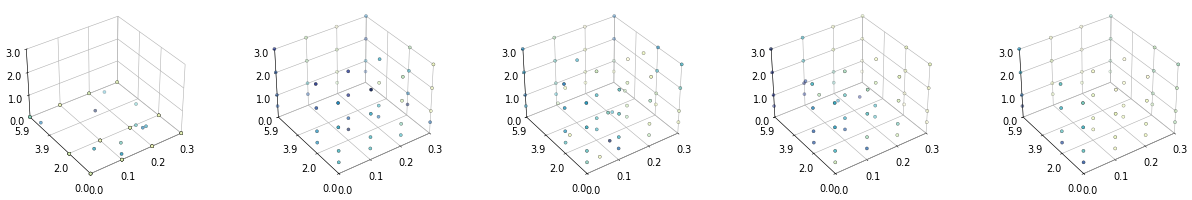

In [13]:
## Generate scatter plots presenting raw data

voltages = db_df['Voltage (V)'].unique()

fig_sca, axs_sca = plt.subplots(1, 5, 
                        subplot_kw=dict(projection='3d'), 
                        gridspec_kw=dict(left=0.02, right=0.98, top=0.95, bottom=0.05), 
                        figsize=(5 * 5, 4), dpi=50)
        
for ax, voltage in zip(axs_sca, voltages):
    sub_df = db_df[db_df['Voltage (V)'] == voltage]
    
    x = sub_df['MXene (mg/mL)']
    y = sub_df['Laminin peptide (ug/mL)']
    z = sub_df['Electric stimulation (Hz)']
    c = sub_df['Cell viability (%)']
    
    sc = ax.scatter(x, y, z, c=c, cmap='YlGnBu', edgecolor='k', linewidths=0.5)
    ax.view_init(elev=35, azim=-125)
    ax.set_xticks((0.0, 0.1, 0.2, 0.3))
    ax.set_yticks((0, 2.0, 3.9, 5.9))
    ax.set_zticks((0.0, 1.0, 2.0, 3.0))
    ax.zaxis.set_major_formatter('{x:.1f}')
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    ax.tick_params(axis='z', labelsize=14)
    ax.set_xlim(0, 0.3)
    ax.set_ylim(0, 5.9)
    ax.set_zlim(0, 3.0)     
    ax.xaxis.set_pane_color((0,0,0,0))
    ax.yaxis.set_pane_color((0,0,0,0))
    ax.zaxis.set_pane_color((0,0,0,0))
        
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    ax.tick_params(axis='z', labelsize=14)

plt.rcParams['font.family'] = 'Arial'
plt.savefig('0519_ANN_scatter.png', dpi=300)  
plt.show()

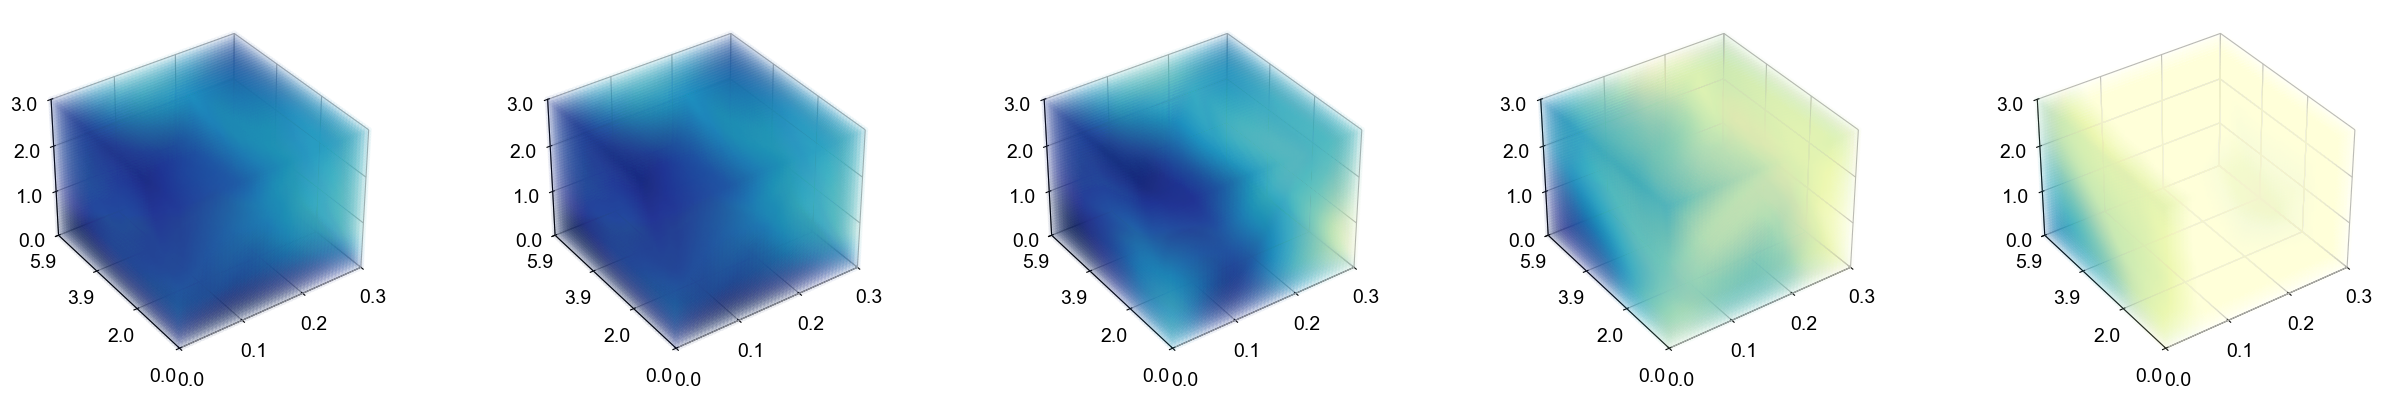

In [14]:
## Generate 3D heatmaps
plt.rcParams['font.family'] = 'Arial'
fig_ANN_heat = ANN_gen_plot(predict=cached_predict2, npts=51, vmin=0.4, vmax=1, vcut=0, af=10, s=20, cmap='YlGnBu', dpi=100)

# fig_ANN_heat.savefig('0519_ANN_3dheatmap.png', dpi=300)

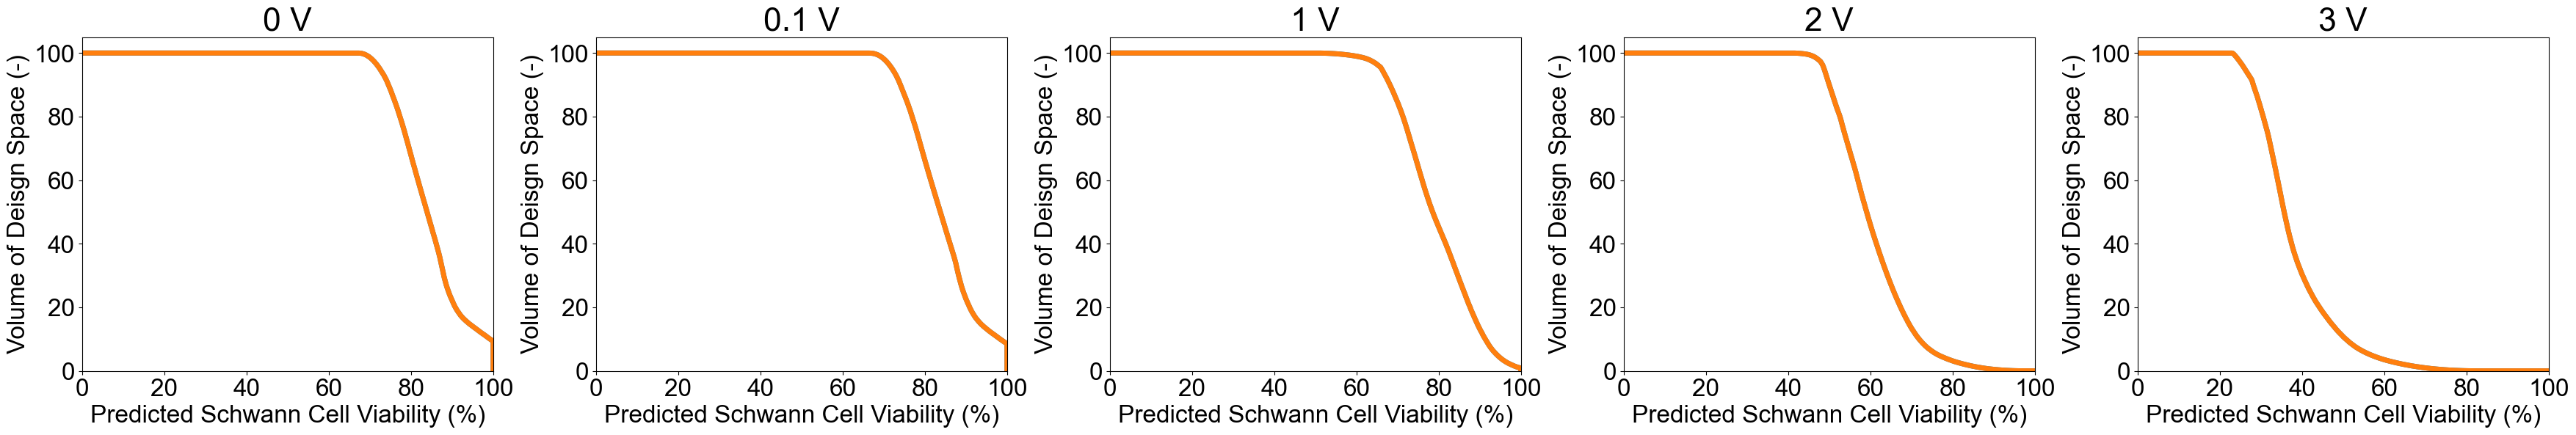

In [15]:
## Generate design space plots

plt.rcParams['font.family'] = 'Arial'
fig_ANN_Vol = ANN_gen_VolPlot(predict=cached_predict2, npts=51, vmin=0, vmax=1.0, vcut=0, af=10, s=20, cmap='YlGnBu', dpi=100, labelsize=24)
#fig_ANN_Vol.savefig('0525_DesignSpace_volume.png', dpi=300)


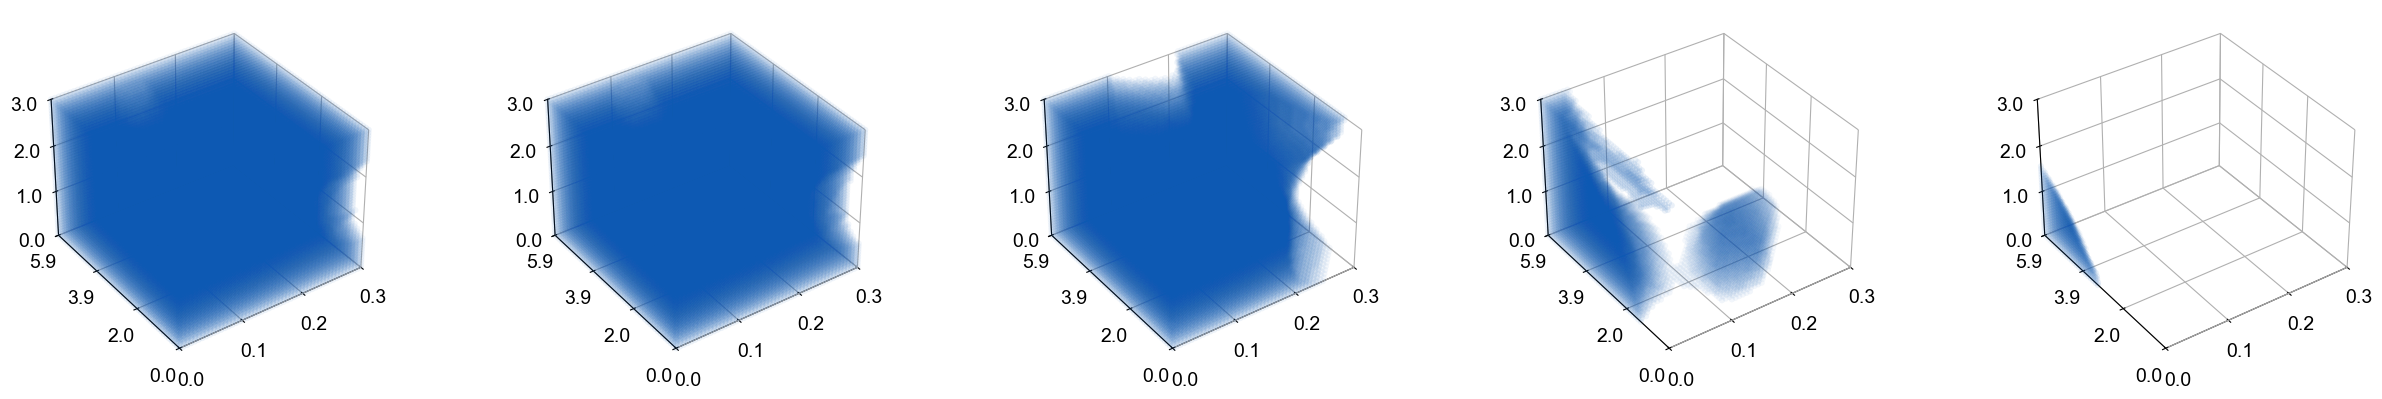

In [18]:
## 3D heatmap presenting regions that cell viability >= 70%
colors_2p = colors
colors_2p[:,:,0:3] = (0.05, 0.35, 0.70)
new_cmap = mcolors.ListedColormap(colors_2p)

fig_ANN_heat = ANN_gen_plot(predict=cached_predict2, npts=51, vmin=0.4, vmax=1, vcut=0.7, af=1, s=20, cmap=new_cmap, dpi=100)
# fig_ANN_heat.savefig('ANN_3dheatmap_cut.png', dpi=300)

In [19]:
## SHAP
import shap

explainer = shap.Explainer(model.predict, scalerX.transform(X_train))
shap_values = explainer(scalerX.transform(X_train))
# shap_values

15/15 [==============================] - 0s 928us/step


Exact explainer:  19%|█▉        | 40/210 [00:00<?, ?it/s]

15/15 [==============================] - 0s 965us/step


Exact explainer:  20%|██        | 42/210 [00:10<00:15, 10.98it/s]

15/15 [==============================] - 0s 998us/step


Exact explainer:  21%|██        | 44/210 [00:10<00:24,  6.84it/s]

15/15 [==============================] - 0s 1ms/step


Exact explainer:  21%|██▏       | 45/210 [00:10<00:26,  6.34it/s]

16/16 [==============================] - 0s 1ms/step


Exact explainer:  22%|██▏       | 46/210 [00:11<00:28,  5.85it/s]

15/15 [==============================] - 0s 1ms/step


Exact explainer:  22%|██▏       | 47/210 [00:11<00:28,  5.77it/s]

16/16 [==============================] - 0s 1ms/step


Exact explainer:  23%|██▎       | 48/210 [00:11<00:28,  5.60it/s]

15/15 [==============================] - 0s 1ms/step


Exact explainer:  23%|██▎       | 49/210 [00:11<00:28,  5.58it/s]

15/15 [==============================] - 0s 1ms/step


Exact explainer:  24%|██▍       | 50/210 [00:11<00:28,  5.52it/s]

14/14 [==============================] - 0s 970us/step


Exact explainer:  24%|██▍       | 51/210 [00:12<00:28,  5.51it/s]

15/15 [==============================] - 0s 1ms/step


Exact explainer:  25%|██▍       | 52/210 [00:12<00:28,  5.48it/s]

15/15 [==============================] - 0s 1ms/step


Exact explainer:  25%|██▌       | 53/210 [00:12<00:28,  5.56it/s]

14/14 [==============================] - 0s 1ms/step


Exact explainer:  26%|██▌       | 54/210 [00:12<00:27,  5.59it/s]

15/15 [==============================] - 0s 930us/step


Exact explainer:  26%|██▌       | 55/210 [00:12<00:27,  5.65it/s]

15/15 [==============================] - 0s 1ms/step


Exact explainer:  27%|██▋       | 56/210 [00:12<00:27,  5.64it/s]

15/15 [==============================] - 0s 859us/step


Exact explainer:  27%|██▋       | 57/210 [00:13<00:27,  5.63it/s]

15/15 [==============================] - 0s 1ms/step


Exact explainer:  28%|██▊       | 58/210 [00:13<00:26,  5.65it/s]

15/15 [==============================] - 0s 1ms/step


Exact explainer:  28%|██▊       | 59/210 [00:13<00:26,  5.65it/s]

14/14 [==============================] - 0s 996us/step


Exact explainer:  29%|██▊       | 60/210 [00:13<00:27,  5.55it/s]

15/15 [==============================] - 0s 930us/step


Exact explainer:  29%|██▉       | 61/210 [00:13<00:27,  5.51it/s]

15/15 [==============================] - 0s 1000us/step


Exact explainer:  30%|██▉       | 62/210 [00:13<00:26,  5.55it/s]

15/15 [==============================] - 0s 928us/step


Exact explainer:  30%|███       | 63/210 [00:14<00:26,  5.57it/s]

15/15 [==============================] - 0s 1ms/step


Exact explainer:  30%|███       | 64/210 [00:14<00:25,  5.62it/s]

16/16 [==============================] - 0s 1ms/step


Exact explainer:  31%|███       | 65/210 [00:14<00:26,  5.52it/s]

15/15 [==============================] - 0s 994us/step


Exact explainer:  31%|███▏      | 66/210 [00:14<00:26,  5.52it/s]

15/15 [==============================] - 0s 965us/step


Exact explainer:  32%|███▏      | 67/210 [00:15<00:32,  4.37it/s]

15/15 [==============================] - 0s 927us/step


Exact explainer:  32%|███▏      | 68/210 [00:15<00:30,  4.69it/s]

15/15 [==============================] - 0s 1ms/step


Exact explainer:  33%|███▎      | 69/210 [00:15<00:28,  4.96it/s]

14/14 [==============================] - 0s 1ms/step


Exact explainer:  33%|███▎      | 70/210 [00:15<00:27,  5.16it/s]

15/15 [==============================] - 0s 1ms/step


Exact explainer:  34%|███▍      | 71/210 [00:15<00:26,  5.22it/s]

15/15 [==============================] - 0s 857us/step


Exact explainer:  34%|███▍      | 72/210 [00:15<00:26,  5.20it/s]

15/15 [==============================] - 0s 1ms/step


Exact explainer:  35%|███▍      | 73/210 [00:16<00:25,  5.32it/s]

14/14 [==============================] - 0s 1ms/step


Exact explainer:  35%|███▌      | 74/210 [00:16<00:25,  5.43it/s]

16/16 [==============================] - 0s 1ms/step


Exact explainer:  36%|███▌      | 75/210 [00:16<00:24,  5.44it/s]

15/15 [==============================] - 0s 929us/step


Exact explainer:  36%|███▌      | 76/210 [00:16<00:24,  5.50it/s]

15/15 [==============================] - 0s 1ms/step


Exact explainer:  37%|███▋      | 77/210 [00:16<00:24,  5.49it/s]

15/15 [==============================] - 0s 929us/step


Exact explainer:  37%|███▋      | 78/210 [00:17<00:23,  5.57it/s]

15/15 [==============================] - 0s 999us/step


Exact explainer:  38%|███▊      | 79/210 [00:17<00:23,  5.67it/s]

15/15 [==============================] - 0s 929us/step


Exact explainer:  38%|███▊      | 80/210 [00:17<00:22,  5.69it/s]

15/15 [==============================] - 0s 966us/step


Exact explainer:  39%|███▊      | 81/210 [00:17<00:22,  5.70it/s]

14/14 [==============================] - 0s 1ms/step


Exact explainer:  39%|███▉      | 82/210 [00:17<00:22,  5.75it/s]

15/15 [==============================] - 0s 999us/step


Exact explainer:  40%|███▉      | 83/210 [00:17<00:22,  5.71it/s]

15/15 [==============================] - 0s 929us/step


Exact explainer:  40%|████      | 84/210 [00:18<00:22,  5.68it/s]

14/14 [==============================] - 0s 922us/step


Exact explainer:  40%|████      | 85/210 [00:18<00:21,  5.74it/s]

15/15 [==============================] - 0s 928us/step


Exact explainer:  41%|████      | 86/210 [00:18<00:21,  5.74it/s]

15/15 [==============================] - 0s 929us/step


Exact explainer:  41%|████▏     | 87/210 [00:18<00:21,  5.71it/s]

16/16 [==============================] - 0s 933us/step


Exact explainer:  42%|████▏     | 88/210 [00:18<00:21,  5.66it/s]

14/14 [==============================] - 0s 927us/step


Exact explainer:  42%|████▏     | 89/210 [00:18<00:21,  5.70it/s]

15/15 [==============================] - 0s 931us/step


Exact explainer:  43%|████▎     | 90/210 [00:19<00:21,  5.58it/s]

15/15 [==============================] - 0s 930us/step


Exact explainer:  43%|████▎     | 91/210 [00:19<00:21,  5.53it/s]

15/15 [==============================] - 0s 929us/step


Exact explainer:  44%|████▍     | 92/210 [00:19<00:21,  5.58it/s]

15/15 [==============================] - 0s 930us/step


Exact explainer:  44%|████▍     | 93/210 [00:19<00:20,  5.64it/s]

14/14 [==============================] - 0s 1ms/step


Exact explainer:  45%|████▍     | 94/210 [00:19<00:20,  5.72it/s]

15/15 [==============================] - 0s 998us/step


Exact explainer:  45%|████▌     | 95/210 [00:20<00:20,  5.67it/s]

15/15 [==============================] - 0s 930us/step


Exact explainer:  46%|████▌     | 96/210 [00:20<00:19,  5.70it/s]

15/15 [==============================] - 0s 928us/step


Exact explainer:  46%|████▌     | 97/210 [00:20<00:19,  5.67it/s]

15/15 [==============================] - 0s 930us/step


Exact explainer:  47%|████▋     | 98/210 [00:20<00:19,  5.64it/s]

16/16 [==============================] - 0s 934us/step


Exact explainer:  47%|████▋     | 99/210 [00:20<00:20,  5.53it/s]

15/15 [==============================] - 0s 930us/step


Exact explainer:  48%|████▊     | 100/210 [00:20<00:20,  5.38it/s]

14/14 [==============================] - 0s 1ms/step


Exact explainer:  48%|████▊     | 101/210 [00:21<00:20,  5.34it/s]

15/15 [==============================] - 0s 930us/step


Exact explainer:  49%|████▊     | 102/210 [00:21<00:19,  5.42it/s]

15/15 [==============================] - 0s 999us/step


Exact explainer:  49%|████▉     | 103/210 [00:21<00:19,  5.52it/s]

15/15 [==============================] - 0s 1ms/step


Exact explainer:  50%|████▉     | 104/210 [00:21<00:19,  5.57it/s]

15/15 [==============================] - 0s 929us/step


Exact explainer:  50%|█████     | 105/210 [00:21<00:18,  5.57it/s]

15/15 [==============================] - 0s 1000us/step


Exact explainer:  50%|█████     | 106/210 [00:22<00:18,  5.58it/s]

15/15 [==============================] - 0s 930us/step


Exact explainer:  51%|█████     | 107/210 [00:22<00:18,  5.56it/s]

15/15 [==============================] - 0s 929us/step


Exact explainer:  51%|█████▏    | 108/210 [00:22<00:18,  5.58it/s]

14/14 [==============================] - 0s 1ms/step


Exact explainer:  52%|█████▏    | 109/210 [00:22<00:17,  5.65it/s]

15/15 [==============================] - 0s 1ms/step


Exact explainer:  52%|█████▏    | 110/210 [00:22<00:17,  5.60it/s]

15/15 [==============================] - 0s 927us/step


Exact explainer:  53%|█████▎    | 111/210 [00:22<00:17,  5.63it/s]

15/15 [==============================] - 0s 1ms/step


Exact explainer:  53%|█████▎    | 112/210 [00:23<00:17,  5.61it/s]

16/16 [==============================] - 0s 934us/step


Exact explainer:  54%|█████▍    | 113/210 [00:23<00:17,  5.53it/s]

16/16 [==============================] - 0s 903us/step


Exact explainer:  54%|█████▍    | 114/210 [00:23<00:17,  5.45it/s]

15/15 [==============================] - 0s 1ms/step


Exact explainer:  55%|█████▍    | 115/210 [00:23<00:17,  5.46it/s]

15/15 [==============================] - 0s 998us/step


Exact explainer:  55%|█████▌    | 116/210 [00:23<00:16,  5.54it/s]

15/15 [==============================] - 0s 931us/step


Exact explainer:  56%|█████▌    | 117/210 [00:23<00:16,  5.54it/s]

15/15 [==============================] - 0s 927us/step


Exact explainer:  56%|█████▌    | 118/210 [00:24<00:16,  5.51it/s]

15/15 [==============================] - 0s 1ms/step


Exact explainer:  57%|█████▋    | 119/210 [00:24<00:16,  5.56it/s]

14/14 [==============================] - 0s 1ms/step


Exact explainer:  57%|█████▋    | 120/210 [00:24<00:16,  5.48it/s]

14/14 [==============================] - 0s 1ms/step


Exact explainer:  58%|█████▊    | 121/210 [00:24<00:16,  5.56it/s]

16/16 [==============================] - 0s 1ms/step


Exact explainer:  58%|█████▊    | 122/210 [00:24<00:15,  5.55it/s]

16/16 [==============================] - 0s 934us/step


Exact explainer:  59%|█████▊    | 123/210 [00:25<00:15,  5.56it/s]

15/15 [==============================] - 0s 964us/step


Exact explainer:  59%|█████▉    | 124/210 [00:25<00:15,  5.52it/s]

15/15 [==============================] - 0s 929us/step


Exact explainer:  60%|█████▉    | 125/210 [00:25<00:15,  5.60it/s]

15/15 [==============================] - 0s 993us/step


Exact explainer:  60%|██████    | 126/210 [00:25<00:14,  5.65it/s]

15/15 [==============================] - 0s 1ms/step


Exact explainer:  60%|██████    | 127/210 [00:25<00:14,  5.68it/s]

15/15 [==============================] - 0s 904us/step


Exact explainer:  61%|██████    | 128/210 [00:25<00:14,  5.67it/s]

15/15 [==============================] - 0s 929us/step


Exact explainer:  61%|██████▏   | 129/210 [00:26<00:14,  5.64it/s]

14/14 [==============================] - 0s 1000us/step


Exact explainer:  62%|██████▏   | 130/210 [00:26<00:14,  5.61it/s]

15/15 [==============================] - 0s 1000us/step


Exact explainer:  62%|██████▏   | 131/210 [00:26<00:14,  5.54it/s]

16/16 [==============================] - 0s 933us/step


Exact explainer:  63%|██████▎   | 132/210 [00:26<00:14,  5.50it/s]

15/15 [==============================] - 0s 1ms/step


Exact explainer:  63%|██████▎   | 133/210 [00:26<00:14,  5.41it/s]

15/15 [==============================] - 0s 1ms/step


Exact explainer:  64%|██████▍   | 134/210 [00:27<00:14,  5.35it/s]

15/15 [==============================] - 0s 1ms/step


Exact explainer:  64%|██████▍   | 135/210 [00:27<00:13,  5.38it/s]

15/15 [==============================] - 0s 1ms/step


Exact explainer:  65%|██████▍   | 136/210 [00:27<00:13,  5.45it/s]

15/15 [==============================] - 0s 999us/step


Exact explainer:  65%|██████▌   | 137/210 [00:27<00:13,  5.53it/s]

15/15 [==============================] - 0s 930us/step


Exact explainer:  66%|██████▌   | 138/210 [00:27<00:13,  5.43it/s]

15/15 [==============================] - 0s 1ms/step


Exact explainer:  66%|██████▌   | 139/210 [00:27<00:13,  5.32it/s]

15/15 [==============================] - 0s 927us/step


Exact explainer:  67%|██████▋   | 140/210 [00:28<00:13,  5.37it/s]

15/15 [==============================] - 0s 1ms/step


Exact explainer:  67%|██████▋   | 141/210 [00:28<00:12,  5.47it/s]

15/15 [==============================] - 0s 1ms/step


Exact explainer:  68%|██████▊   | 142/210 [00:28<00:12,  5.50it/s]

15/15 [==============================] - 0s 929us/step


Exact explainer:  68%|██████▊   | 143/210 [00:28<00:11,  5.61it/s]

15/15 [==============================] - 0s 1ms/step


Exact explainer:  69%|██████▊   | 144/210 [00:28<00:11,  5.57it/s]

15/15 [==============================] - 0s 967us/step


Exact explainer:  69%|██████▉   | 145/210 [00:29<00:11,  5.56it/s]

15/15 [==============================] - 0s 1ms/step


Exact explainer:  70%|██████▉   | 146/210 [00:29<00:11,  5.48it/s]

15/15 [==============================] - 0s 857us/step


Exact explainer:  70%|███████   | 147/210 [00:29<00:11,  5.46it/s]

15/15 [==============================] - 0s 1ms/step


Exact explainer:  70%|███████   | 148/210 [00:29<00:11,  5.52it/s]

15/15 [==============================] - 0s 1000us/step


Exact explainer:  71%|███████   | 149/210 [00:29<00:10,  5.61it/s]

16/16 [==============================] - 0s 999us/step


Exact explainer:  71%|███████▏  | 150/210 [00:29<00:10,  5.47it/s]

14/14 [==============================] - 0s 1ms/step


Exact explainer:  72%|███████▏  | 151/210 [00:30<00:10,  5.50it/s]

16/16 [==============================] - 0s 867us/step


Exact explainer:  72%|███████▏  | 152/210 [00:30<00:10,  5.40it/s]

15/15 [==============================] - 0s 1ms/step


Exact explainer:  73%|███████▎  | 153/210 [00:30<00:10,  5.46it/s]

15/15 [==============================] - 0s 1ms/step


Exact explainer:  73%|███████▎  | 154/210 [00:30<00:10,  5.53it/s]

14/14 [==============================] - 0s 1ms/step


Exact explainer:  74%|███████▍  | 155/210 [00:30<00:09,  5.61it/s]

15/15 [==============================] - 0s 1ms/step


Exact explainer:  74%|███████▍  | 156/210 [00:31<00:09,  5.65it/s]

15/15 [==============================] - 0s 929us/step


Exact explainer:  75%|███████▍  | 157/210 [00:31<00:09,  5.70it/s]

15/15 [==============================] - 0s 858us/step


Exact explainer:  75%|███████▌  | 158/210 [00:31<00:09,  5.66it/s]

15/15 [==============================] - 0s 929us/step


Exact explainer:  76%|███████▌  | 159/210 [00:31<00:08,  5.71it/s]

15/15 [==============================] - 0s 1ms/step


Exact explainer:  76%|███████▌  | 160/210 [00:31<00:08,  5.72it/s]

15/15 [==============================] - 0s 926us/step


Exact explainer:  77%|███████▋  | 161/210 [00:31<00:08,  5.70it/s]

15/15 [==============================] - 0s 858us/step


Exact explainer:  77%|███████▋  | 162/210 [00:32<00:08,  5.72it/s]

15/15 [==============================] - 0s 930us/step


Exact explainer:  78%|███████▊  | 163/210 [00:32<00:08,  5.74it/s]

15/15 [==============================] - 0s 927us/step


Exact explainer:  78%|███████▊  | 164/210 [00:32<00:07,  5.77it/s]

15/15 [==============================] - 0s 929us/step


Exact explainer:  79%|███████▊  | 165/210 [00:32<00:07,  5.73it/s]

15/15 [==============================] - 0s 929us/step


Exact explainer:  79%|███████▉  | 166/210 [00:32<00:07,  5.79it/s]

15/15 [==============================] - 0s 893us/step


Exact explainer:  80%|███████▉  | 167/210 [00:32<00:07,  5.77it/s]

15/15 [==============================] - 0s 929us/step


Exact explainer:  80%|████████  | 168/210 [00:33<00:07,  5.73it/s]

15/15 [==============================] - 0s 1ms/step


Exact explainer:  80%|████████  | 169/210 [00:33<00:07,  5.68it/s]

15/15 [==============================] - 0s 999us/step


Exact explainer:  81%|████████  | 170/210 [00:33<00:07,  5.67it/s]

15/15 [==============================] - 0s 929us/step


Exact explainer:  81%|████████▏ | 171/210 [00:33<00:06,  5.67it/s]

14/14 [==============================] - 0s 926us/step


Exact explainer:  82%|████████▏ | 172/210 [00:33<00:06,  5.75it/s]

15/15 [==============================] - 0s 929us/step


Exact explainer:  82%|████████▏ | 173/210 [00:34<00:06,  5.75it/s]

15/15 [==============================] - 0s 1ms/step


Exact explainer:  83%|████████▎ | 174/210 [00:34<00:06,  5.73it/s]

15/15 [==============================] - 0s 899us/step


Exact explainer:  83%|████████▎ | 175/210 [00:34<00:06,  5.71it/s]

15/15 [==============================] - 0s 1ms/step


Exact explainer:  84%|████████▍ | 176/210 [00:34<00:05,  5.75it/s]

15/15 [==============================] - 0s 928us/step


Exact explainer:  84%|████████▍ | 177/210 [00:34<00:05,  5.75it/s]

15/15 [==============================] - 0s 1ms/step


Exact explainer:  85%|████████▍ | 178/210 [00:34<00:05,  5.71it/s]

15/15 [==============================] - 0s 897us/step


Exact explainer:  85%|████████▌ | 179/210 [00:35<00:05,  5.75it/s]

15/15 [==============================] - 0s 853us/step


Exact explainer:  86%|████████▌ | 180/210 [00:35<00:05,  5.74it/s]

15/15 [==============================] - 0s 928us/step


Exact explainer:  86%|████████▌ | 181/210 [00:35<00:05,  5.73it/s]

16/16 [==============================] - 0s 935us/step


Exact explainer:  87%|████████▋ | 182/210 [00:35<00:04,  5.62it/s]

15/15 [==============================] - 0s 927us/step


Exact explainer:  87%|████████▋ | 183/210 [00:35<00:04,  5.61it/s]

16/16 [==============================] - 0s 1ms/step


Exact explainer:  88%|████████▊ | 184/210 [00:35<00:04,  5.58it/s]

15/15 [==============================] - 0s 857us/step


Exact explainer:  88%|████████▊ | 185/210 [00:36<00:04,  5.68it/s]

15/15 [==============================] - 0s 924us/step


Exact explainer:  89%|████████▊ | 186/210 [00:36<00:04,  5.71it/s]

15/15 [==============================] - 0s 894us/step


Exact explainer:  89%|████████▉ | 187/210 [00:36<00:04,  5.74it/s]

15/15 [==============================] - 0s 941us/step


Exact explainer:  90%|████████▉ | 188/210 [00:36<00:03,  5.71it/s]

14/14 [==============================] - 0s 923us/step


Exact explainer:  90%|█████████ | 189/210 [00:36<00:03,  5.69it/s]

15/15 [==============================] - 0s 926us/step


Exact explainer:  90%|█████████ | 190/210 [00:36<00:03,  5.71it/s]

15/15 [==============================] - 0s 971us/step


Exact explainer:  91%|█████████ | 191/210 [00:37<00:03,  5.74it/s]

16/16 [==============================] - 0s 1ms/step


Exact explainer:  91%|█████████▏| 192/210 [00:37<00:03,  5.59it/s]

15/15 [==============================] - 0s 927us/step


Exact explainer:  92%|█████████▏| 193/210 [00:37<00:03,  5.65it/s]

15/15 [==============================] - 0s 924us/step


Exact explainer:  92%|█████████▏| 194/210 [00:37<00:02,  5.73it/s]

15/15 [==============================] - 0s 932us/step


Exact explainer:  93%|█████████▎| 195/210 [00:37<00:02,  5.73it/s]

14/14 [==============================] - 0s 1ms/step


Exact explainer:  93%|█████████▎| 196/210 [00:38<00:02,  5.73it/s]

15/15 [==============================] - 0s 929us/step


Exact explainer:  94%|█████████▍| 197/210 [00:38<00:02,  5.70it/s]

15/15 [==============================] - 0s 929us/step


Exact explainer:  94%|█████████▍| 198/210 [00:38<00:02,  5.76it/s]

14/14 [==============================] - 0s 891us/step


Exact explainer:  95%|█████████▍| 199/210 [00:38<00:01,  5.76it/s]

15/15 [==============================] - 0s 930us/step


Exact explainer:  95%|█████████▌| 200/210 [00:38<00:01,  5.79it/s]

16/16 [==============================] - 0s 933us/step


Exact explainer:  96%|█████████▌| 201/210 [00:38<00:01,  5.59it/s]

15/15 [==============================] - 0s 1ms/step


Exact explainer:  96%|█████████▌| 202/210 [00:39<00:01,  5.62it/s]

15/15 [==============================] - 0s 928us/step


Exact explainer:  97%|█████████▋| 203/210 [00:39<00:01,  5.54it/s]

15/15 [==============================] - 0s 1ms/step


Exact explainer:  97%|█████████▋| 204/210 [00:39<00:01,  5.51it/s]

15/15 [==============================] - 0s 928us/step


Exact explainer:  98%|█████████▊| 205/210 [00:39<00:00,  5.59it/s]

15/15 [==============================] - 0s 1ms/step


Exact explainer:  98%|█████████▊| 206/210 [00:39<00:00,  5.58it/s]

15/15 [==============================] - 0s 999us/step


Exact explainer:  99%|█████████▊| 207/210 [00:40<00:00,  5.63it/s]

14/14 [==============================] - 0s 923us/step


Exact explainer:  99%|█████████▉| 208/210 [00:40<00:00,  5.63it/s]

16/16 [==============================] - 0s 935us/step


Exact explainer: 100%|█████████▉| 209/210 [00:40<00:00,  5.68it/s]

15/15 [==============================] - 0s 857us/step


Exact explainer: 100%|██████████| 210/210 [00:40<00:00,  5.67it/s]

14/14 [==============================] - 0s 927us/step


Exact explainer: 211it [00:40,  4.20it/s]                         


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
FixedFormatter should only be used together with FixedLocator
Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


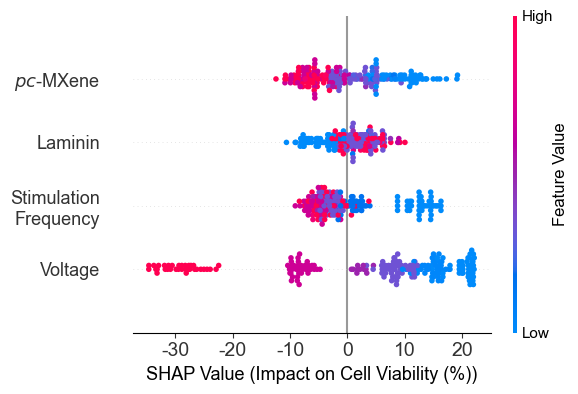

In [20]:
plt.close('all')

plt.rcParams['font.family'] = 'Arial'

# Initialize a new figure
fig = plt.figure()

shap.summary_plot(shap_values, scalerX.transform(X_train), 
                 feature_names=[r'$\mathit{pc}$' + '-MXene', 'Laminin', 'Stimulation\nFrequency', 'Voltage'], sort=False, show=False, plot_size=[6, 4], color_bar_label='Feature Value')

# Retrieve the current figure and axis
S = plt.gcf()
ax = plt.gca()

x_ticks = ax.get_xticks()
ax.set_xticklabels([int(round(tick * 100, 0)) for tick in x_ticks], fontsize=14)
ax.set_xlabel('SHAP Value (Impact on Cell Viability (%))')

# Save the figure
# fig.savefig('0525_Shap_Summary.png', dpi=600)
S.show()


Text(31.049999999999997, 0.5, "Spearman's Correlation")

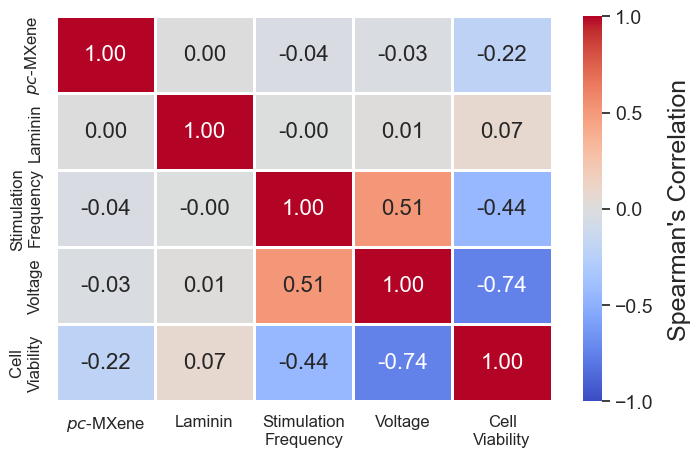

In [21]:
plt.close('all')

sns.set(rc={'font.family': 'Arial'})
dfs = pd.DataFrame({'MXene': db_df['MXene (mg/mL)'],
                   'Laminin\npeptide': db_df['Laminin peptide (ug/mL)'],
                   'Electric\nstimulation': db_df['Electric stimulation (Hz)'],
                   'Voltage': db_df['Voltage (V)'],
                   'Cell viability': db_df['Cell viability (%)']})

corr = dfs.corr(method = 'spearman')

# Plot
new_cmap = sns.color_palette("coolwarm", as_cmap=True)
heatmap = sns.heatmap(corr, annot=True, fmt=".2f", vmin=-1.0, cmap=new_cmap, linewidth=1, annot_kws={"fontsize": 16},
                      xticklabels=[r'$\mathit{pc}$' + '-MXene', 'Laminin', 'Stimulation\nFrequency', 'Voltage', 'Cell\nViability'],
                      yticklabels=[r'$\mathit{pc}$' + '-MXene', 'Laminin', 'Stimulation\nFrequency', 'Voltage', 'Cell   \nViability'])

heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=12, rotation=0)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=12, rotation=90, va='center')

# Adjust cbar
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)
ticks = [-1.0, -0.5, 0.0, 0.5, 1.0]
cbar.set_ticks(ticks)

F = plt.gcf()
F.set_size_inches(8, 5)
ax = plt.gca()
ax.set_ylabel("Spearman's Correlation", fontsize=18, loc='center', labelpad=-490, fontname="Arial")
# F.savefig('0525_Spearmans', dpi=600)
# F.show()


Text(31.049999999999997, 0.5, 'p-value')

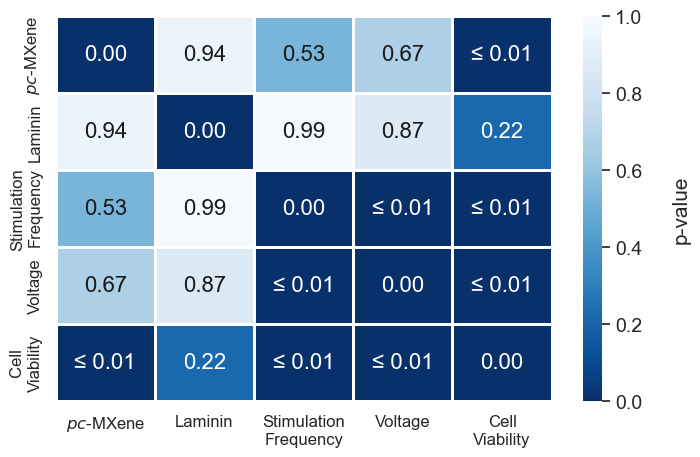

In [22]:
plt.close('all')
# Spearmans' analysis
res, pvalue = stats.spearmanr(db_df[x_cols], db_df['Cell viability (%)'])

sns.set(rc={'font.family': 'Arial'})
dfs = pd.DataFrame({'MXene': db_df['MXene (mg/mL)'],
                   'Laminin\npeptide': db_df['Laminin peptide (ug/mL)'],
                   'Electric\nstimulation': db_df['Electric stimulation (Hz)'],
                   'Voltage': db_df['Voltage (V)'],
                   'Cell viability': db_df['Cell viability (%)']})

corr = dfs.corr(method = 'spearman')

new_cmap = sns.color_palette("Blues_r", as_cmap=True)
heatmap_p = sns.heatmap(pvalue, annot=False, fmt=".2f", vmax=1.0, vmin=0.0, cmap=new_cmap, linewidth=1, annot_kws={"fontsize": 16},
                      xticklabels=[r'$\mathit{pc}$' + '-MXene', 'Laminin', 'Stimulation\nFrequency', 'Voltage', 'Cell\nViability'],
                      yticklabels=[r'$\mathit{pc}$' + '-MXene', 'Laminin', 'Stimulation\nFrequency', 'Voltage', 'Cell   \nViability'])

for i in range(len(pvalue)):
    for j in range(len(pvalue[0])):
        if pvalue[i][j] < 0.01:
            if i == j:
                heatmap_p.text(j+0.5, i+0.5, '0.00', ha='center', va='center', fontsize=16, color='w', fontname = 'Arial')
            else:
                heatmap_p.text(j+0.5, i+0.5, '≤ 0.01', ha='center', va='center', fontsize=16, color='w', fontname='Arial')
        elif pvalue[i][j] <= 0.5:
            heatmap_p.text(j+0.5, i+0.5,f'{np.round(pvalue[i][j], decimals=2)}',ha='center', va='center', fontsize=16, color='w', fontname='Arial')
        else:
            heatmap_p.text(j+0.5, i+0.5,f'{np.round(pvalue[i][j], decimals=2)}',ha='center', va='center', fontsize=16, color='k', fontname='Arial')
                
heatmap_p.set_xticklabels(heatmap_p.get_xticklabels(), fontsize=12, rotation=0)
heatmap_p.set_yticklabels(heatmap_p.get_yticklabels(), fontsize=12, rotation=90, va='center')

# Adjust cbar
cbar = heatmap_p.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)
ticks = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
cbar.set_ticks(ticks)

P = plt.gcf()
P.set_size_inches(8, 5)
ax = plt.gca()
ax.set_ylabel('p-value', fontsize=15, loc='center', labelpad=-490, fontname="Arial")
# P.savefig('0525_p_Spearmans', dpi=600)
# F.show()
